Logistic Regression
=========

Libraries:

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_fscore_support, auc, accuracy_score

#### Read Data:

In [2]:
data = pd.read_csv("/media/juanan/DATA/loan_data_analysis/data/loans_sample_processed.csv", sep = "^")

In [3]:
data.head()

,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,delinq_amnt,dti,fico_range_high,fico_range_low,funded_amnt,...,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,term_ 36 months,term_ 60 months,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,87000.0,12413.0,5310.0,45.0,0.0,0.0,22.21,694.0,690.0,20000.0,...,0,0,0,0,0,1,0,0,0,1
1,60000.0,1982.0,14989.0,35.1,0.0,0.0,19.14,669.0,665.0,12000.0,...,0,1,0,0,0,0,1,0,0,1
2,55000.0,3261.0,6967.0,18.0,0.0,0.0,15.40,709.0,705.0,11000.0,...,0,0,0,0,0,0,1,1,0,0
3,72000.0,28457.0,344.0,93.1,0.0,0.0,8.85,684.0,680.0,20000.0,...,0,0,0,0,0,0,1,0,1,0
4,115000.0,21020.0,519.0,71.2,0.0,0.0,5.22,664.0,660.0,24000.0,...,0,0,0,0,0,1,0,1,0,0


In [4]:
data.shape

(57861, 168)

#### Pre-processing:

Scale:

In [5]:
numeric_variables = data._get_numeric_data().columns

In [6]:
scaler = RobustScaler()

In [7]:
scaler.fit(data[numeric_variables])

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [8]:
data[numeric_variables] = scaler.transform(data[numeric_variables])

In [9]:
data.head()

,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,delinq_amnt,dti,fico_range_high,fico_range_low,funded_amnt,...,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,term_ 36 months,term_ 60 months,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,0.842857,0.569122,0.276904,-0.519722,0.0,0.0,0.398810,0.142857,0.142857,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.071429,-0.277138,1.612307,-0.749420,0.0,0.0,0.137755,-0.571429,-0.571429,0.106145,...,0.0,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,1.0
2,-0.071429,-0.173373,0.505519,-1.146172,0.0,0.0,-0.180272,0.571429,0.571429,-0.005587,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.0,0.0
3,0.414286,1.870761,-0.408251,0.596288,0.0,0.0,-0.737245,-0.142857,-0.142857,1.000000,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,0.0
4,1.642857,1.267402,-0.384106,0.088167,0.0,0.0,-1.045918,-0.714286,-0.714286,1.446927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
data = data.loc[:,data.columns != 'last_fico_range_high']

One-hot_encoding:

In [11]:
categorical_variables = data.select_dtypes(include="object").columns
data = pd.get_dummies(data, categorical_variables)

In [12]:
data.shape

(57861, 168)

Train / Test split:

In [13]:
X = data.loc[:, data.columns!='loan_status']

In [14]:
y = data['loan_status']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4290)

__Prior__:

In [16]:
y.value_counts()[0] / len(y)

0.7964259172845267

__Logistic Regression__:

In [17]:
log_reg = LogisticRegression(penalty='l2',C=1)

In [18]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
log_reg.predict_proba(X_test)

array([[0.83249565, 0.16750435],
       [0.80586261, 0.19413739],
       [0.95898539, 0.04101461],
       ...,
       [0.96588253, 0.03411747],
       [0.80118923, 0.19881077],
       [0.87114896, 0.12885104]])

__Model Evaluation__

AUC in the train set:

In [20]:
y_scores_train = log_reg.predict_proba(X_train)

y_scores_train = pd.DataFrame(y_scores_train).loc[:,1]

In [21]:
roc_auc_score(y_train, y_scores_train)

0.7157759364277306

ROC Curve:

In [22]:
y_scores = log_reg.predict_proba(X_test)

y_scores = pd.DataFrame(y_scores).loc[:,1]

In [23]:
fpr, tpr, _ = roc_curve(y_test, y_scores)

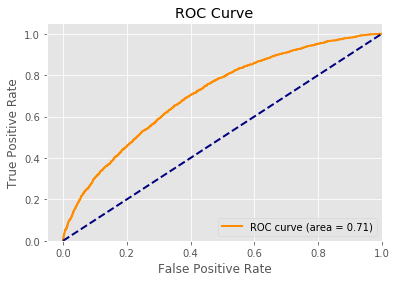

In [24]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

AUC:

In [25]:
roc_auc_score(y_test, y_scores)

0.7088365410020676

Confusion Matrix

In [26]:
y_predictions = log_reg.predict(X_test)

In [27]:
confusion_matrix(y_test, y_predictions)

array([[9042,  137],
       [2198,  196]])

Accuracy:

In [28]:
accuracy_score(y_test, y_predictions)

0.7982372764192517

Recall:

In [29]:
precision_recall_fscore_support(y_test, y_predictions) [0]

array([0.8044484 , 0.58858859])

Precision:

In [30]:
precision_recall_fscore_support(y_test, y_predictions) [1]

array([0.98507463, 0.08187135])

__Output__:

In [32]:
y_scores_train.to_csv("../output/y_scores_train_logit.csv", sep = "^", index = False)
y_scores.to_csv("../output/y_scores_test_logit.csv", sep = "^", index = False)